In [236]:
# imports and laodings
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statistics
from scipy.optimize import minimize, basinhopping

# settings
central_gene = 'b1817'
basal_conditions = ['control__wt_glc__1', 'control__wt_glc__2'] #'crp__delar1ar2_glyc__2'

A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
A_df = A_df[log_tpm_df.columns]

# loading in
df_name = central_gene+'_zerodTrue_mRNA_ratios_and_MA_vals.csv'
ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
ratios_df = ratios_df.sort_values(by = 'actual_mRNA_ratio')
f_name = central_gene+'_zerodTrue_cAct_cInh_vals.csv'
cActInh_df = pd.read_csv('../data/save_for_GAMs/'+f_name, index_col = 0)

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df = pd.read_csv('../data/save_for_GAMs/exported_TF_conc.csv', index_col = 0)

# defining constants
#RNAP = 1*10**(-8)
RNAP = 1*10**(-7)
kEscape = 1
TF = 0
#u = 1/3600
#kDeg = 0.00231049
#promoterConc = 1*10**(-9)
#promoterConcVal = 10**(-9)
#cell_volume = 10**(-15) # in liters

# getting grid values
pickle_in = open('../data/pickle_dicts/center_cond_to_gene_to_grid_values.pkl', 'rb')
center_cond_to_gene_to_grid_values = pickle.load(pickle_in)
pickle_in.close()
grid_vals = center_cond_to_gene_to_grid_values[basal_conditions[0]]['b1101']
grid_use = -3
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = 2.5118864315095796e-07*1.4

print(KdRNAP)
#print(kEscape)
print(KeqOpening)

if True:
    def mRNA_to_cActivator(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening): # this appears to be properly working!
        cActivator = (KdRNAPCrp*(KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + \
                mRNA))/(KdRNAP*(KdRNAP + RNAP + KeqOpening*RNAP - \
                KdRNAPCrp*mRNA - RNAP*mRNA - KeqOpening*RNAP*mRNA))

        return(cActivator)

    def mRNA_to_cInhibitor(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KeqOpening = KeqOpening): # I think the mathematica code might have an error, I'm sticking with this
        cInhibitor = -(((KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + mRNA))/(KdRNAP*mRNA))

        return(cInhibitor)


    def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening):
        mRNA = ((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
                KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
                cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
                KeqOpening)*RNAP)

        return(mRNA)

    def log_tpm_to_mRNA_conc(val):
        mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
        return(mRNA)

1e-05
0.4524289955987184


# optimize KdRNAPCrp

Optimal KdRNAPCrp = 1.09e-06, score = -0.55


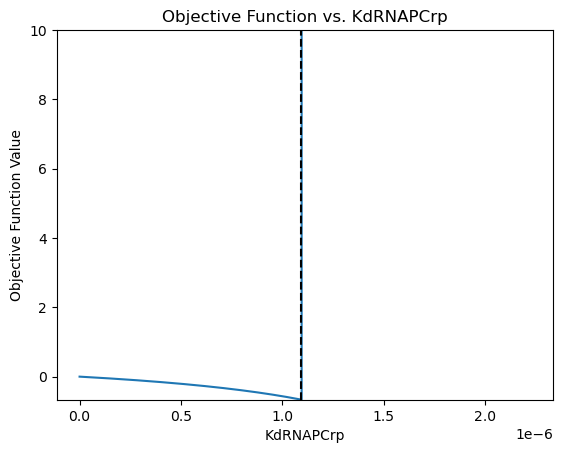

In [248]:
# first let's find the point at which cAct is no longer negative at higher mRNA ratios
def objective_function1(KdRNAPCrp_temp):
    cActs = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = KdRNAPCrp_temp)
    
    # Set up penalty
    penalty = 0
    # Penalize heavily if higher mRNA ratio end is negative (negative lower end is not abnormal as that'll normally be repression)
    if min(cActs[-10:].values.flatten()) < 0:
        penalty -= 5*KdRNAP
        
    penalty += KdRNAPCrp_temp # I want the lowest value for which this happens
    
    return(penalty)

# setup and minimize
initial_guess = KdRNAP
bounds = [(1e-9, KdRNAP)]
result1 = minimize(objective_function, initial_guess, bounds = bounds, tol = 1e-10)
max_KdRNAPCrp = result1.x[0] 


# now with our new maximum, let's look for the ideal value (and we can ignore negative value penalty I think)
# Define your objective function
closest_index = min(range(len(ratios_df['actual_mRNA_ratio'])), key=lambda i: abs(ratios_df['actual_mRNA_ratio'][i] - .50*max(ratios_df['actual_mRNA_ratio'])))
max_index = min(range(len(ratios_df['actual_mRNA_ratio'])), key=lambda i: abs(ratios_df['actual_mRNA_ratio'][i] - max(ratios_df['actual_mRNA_ratio'])))
def objective_function2(KdRNAPCrp_temp):
    cActs = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = KdRNAPCrp_temp).values.flatten()
    
    # Set up penalty
    penalty = 0
    # Penalize heavily if higher mRNA ratio end is negative (negative lower end is not abnormal as that'll normally be repression)
    if min(cActs[-10:]) < 0:
        penalty += 1000
    else:
        # Penalize cActivator range based on closeness to GAM model options
        # GAMS calculated cActivators
        max_cAct = max(scaled_df.values.flatten()) / 10**-9  # max_TF_conc / min_kd
        min_cAct = 0  # min_TF_conc / max_kd
        #penalty -= abs((max(cActs) - min(cActs)))# - (max_cAct - 0)) # penalize if range is not correct
        
        # If you just take max, it picks something with a huge extreme, instead maximize the 50th percentile value
        penalty -= cActs[closest_index]
        
    return(penalty)

# setup and minimize
initial_guess = max_KdRNAPCrp / 2
bounds = [(max_KdRNAPCrp / 1000, max_KdRNAPCrp*10)]
result2 = basinhopping(objective_function2, initial_guess, stepsize = 1e-7)

# The optimal KdRNAPCrp value
optimal_KdRNAPCrp = result2.x[0]
print("Optimal KdRNAPCrp = {:.2e}".format(optimal_KdRNAPCrp), end = ', score = ')
print('{:.2f}'.format(result.fun))

# Define the range of KdRNAPCrp values for plotting
KdRNAPCrp_values = np.linspace(0, max_KdRNAPCrp*2, 1000)  # Adjust the range as needed

# Calculate the objective function values for each KdRNAPCrp value
objective_values = [objective_function2(KdRNAPCrp) for KdRNAPCrp in KdRNAPCrp_values]

# Create a plot to visualize the objective function
plt.plot(KdRNAPCrp_values, objective_values)
plt.axvline(x = optimal_KdRNAPCrp, c = 'k', ls = '--')
plt.ylim(min(objective_values), 10)
plt.xlabel('KdRNAPCrp')
plt.ylabel('Objective Function Value')
plt.title('Objective Function vs. KdRNAPCrp')
plt.show()

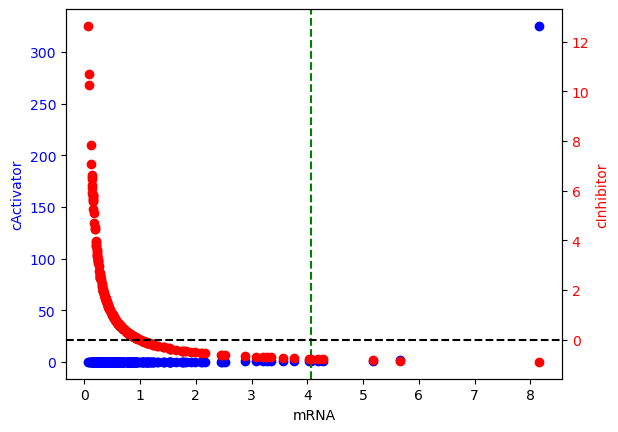

In [252]:
# now plot this result
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it


# plot
fig, ax = plt.subplots()
vals = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = optimal_KdRNAPCrp)
ax.scatter(ratios_df['actual_mRNA_ratio'], vals, c = 'blue')
vals = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = 0.5*optimal_KdRNAPCrp)
#ax.scatter(ratios_df['actual_mRNA_ratio'], vals, c = 'cyan')
vals = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = 2*optimal_KdRNAPCrp)
#ax.scatter(ratios_df['actual_mRNA_ratio'], vals, c = 'darkblue')
plt.xlabel('mRNA')

closest_index = min(range(len(ratios_df['actual_mRNA_ratio'])), key=lambda i: abs(ratios_df['actual_mRNA_ratio'][i] - .50*max(ratios_df['actual_mRNA_ratio'])))
plt.axvline(x = ratios_df['actual_mRNA_ratio'][closest_index], c = 'green', ls = '--')

ax.set_ylabel('cActivator', color = 'blue')
ax.tick_params(axis = 'y', labelcolor = 'blue')
#ax.set_ylim(-max(abs(vals)), max(abs(vals)))
ax2 = ax.twinx()
vals = mRNA_to_cInhibitor(ratios_df['actual_mRNA_ratio'])
ax2.scatter(ratios_df['actual_mRNA_ratio'], vals, color = 'red')
ax2.set_ylabel('cInhibitor', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
#ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
#plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
#plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
ax2.axhline(y = 0, linestyle = '--', color = 'k')
plt.show()

1e-05


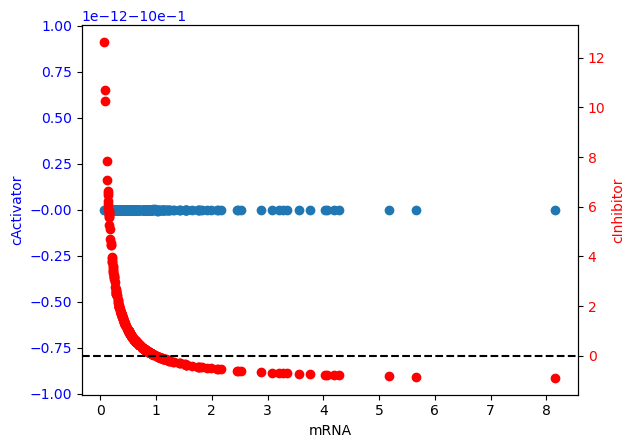

6.309573444801933e-06


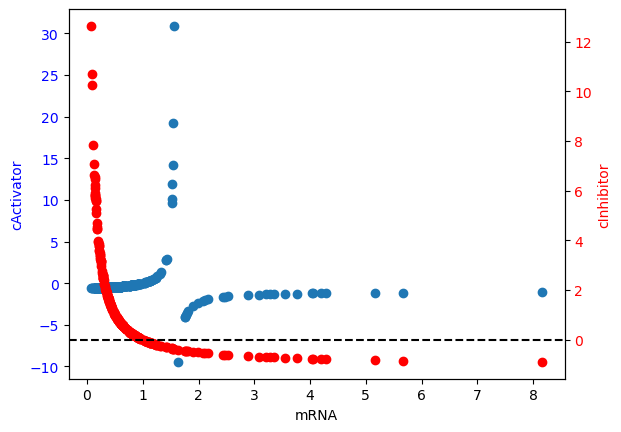

3.9810717055349725e-06


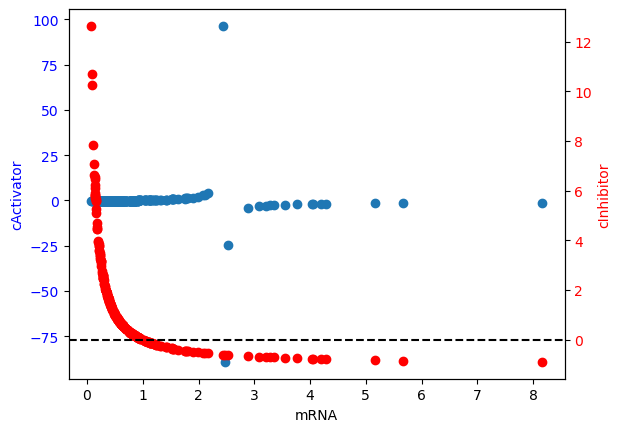

2.51188643150958e-06


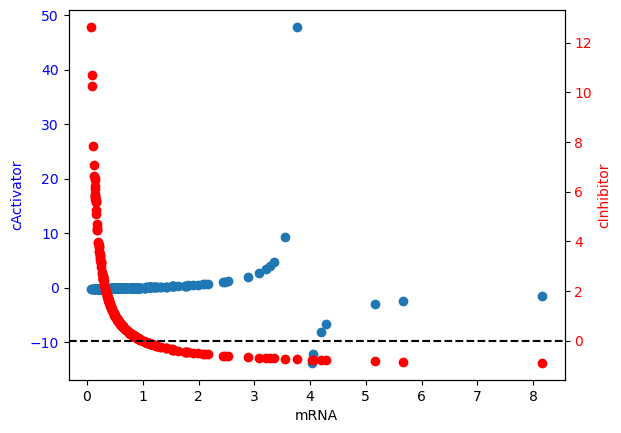

1.5848931924611137e-06


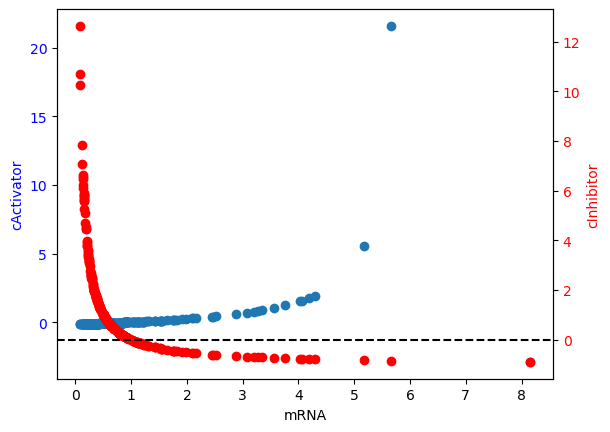

1.0000000000000002e-06


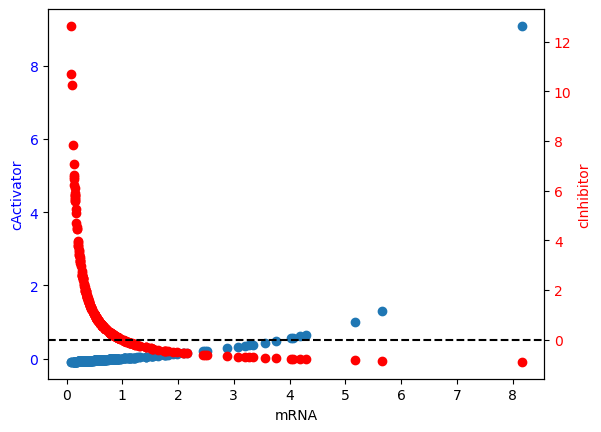

6.309573444801934e-07


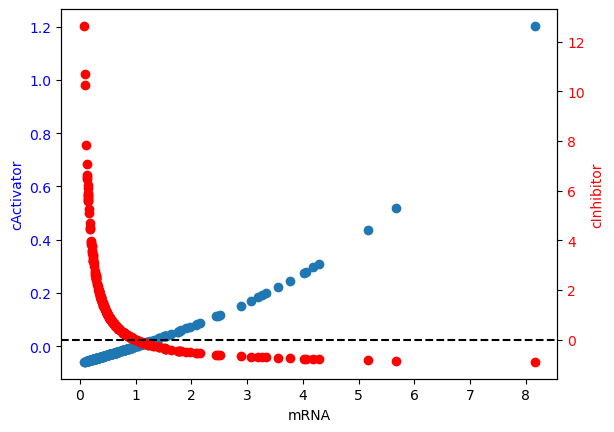

3.981071705534974e-07


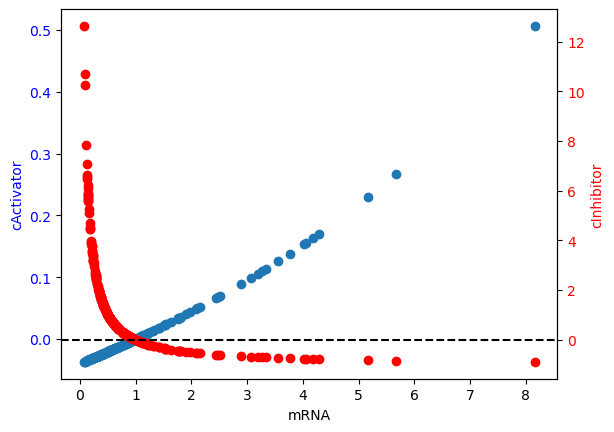

2.5118864315095796e-07


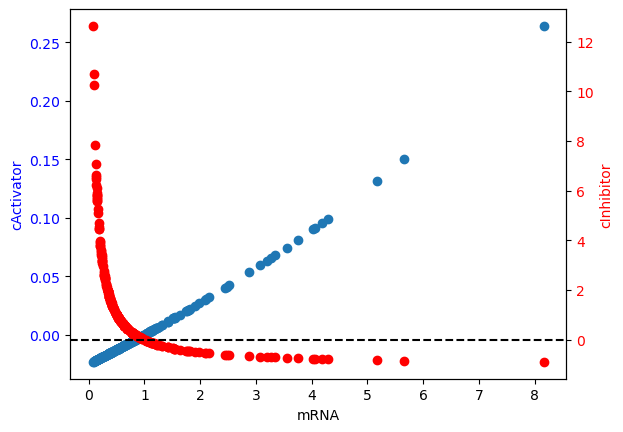

1.5848931924611136e-07


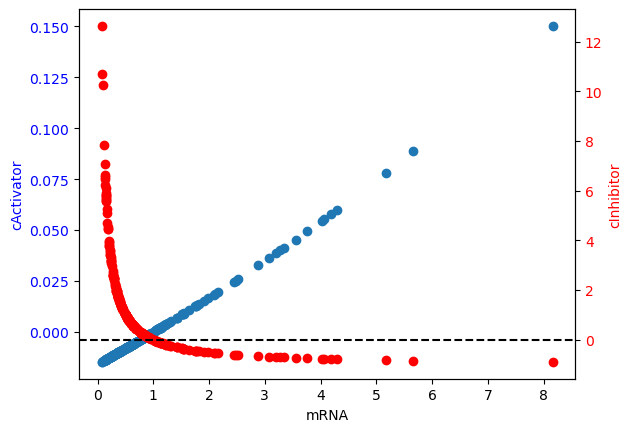

1.0000000000000001e-07


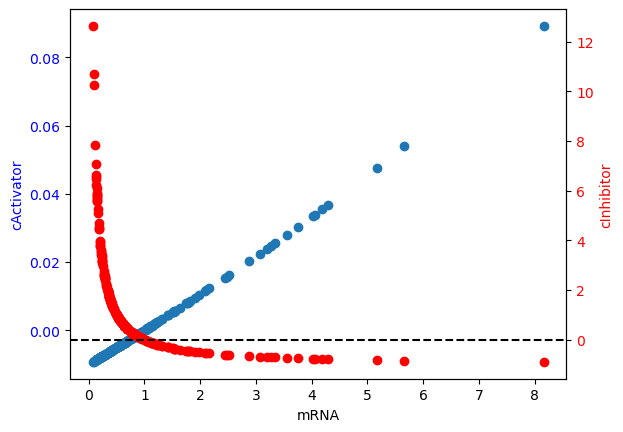

6.309573444801931e-08


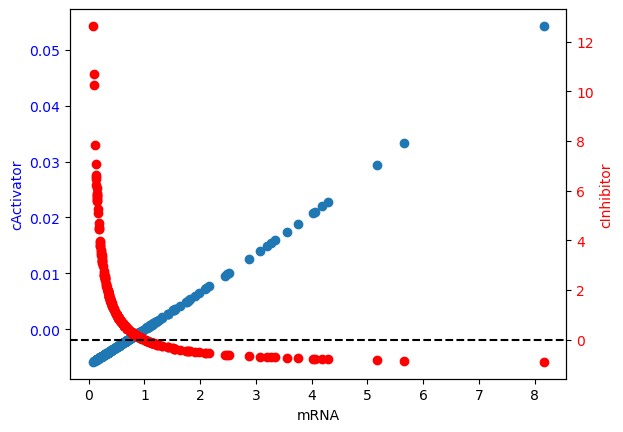

3.9810717055349736e-08


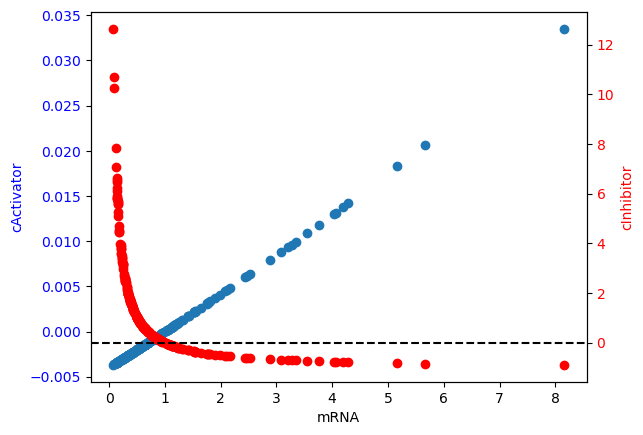

2.5118864315095798e-08


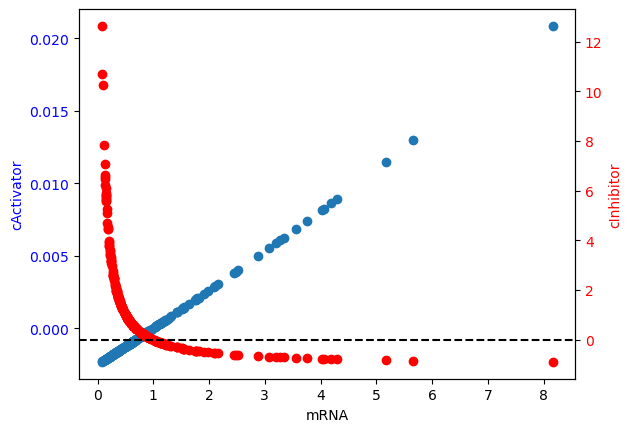

1.5848931924611143e-08


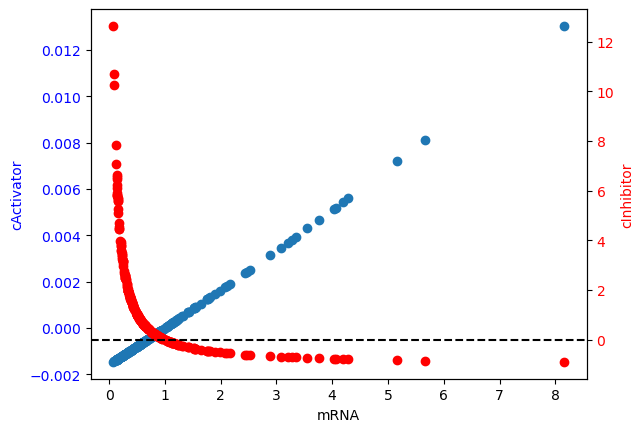

1e-08


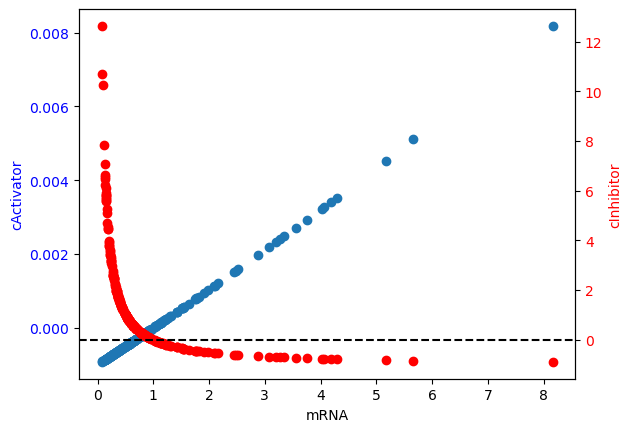

6.3095734448019305e-09


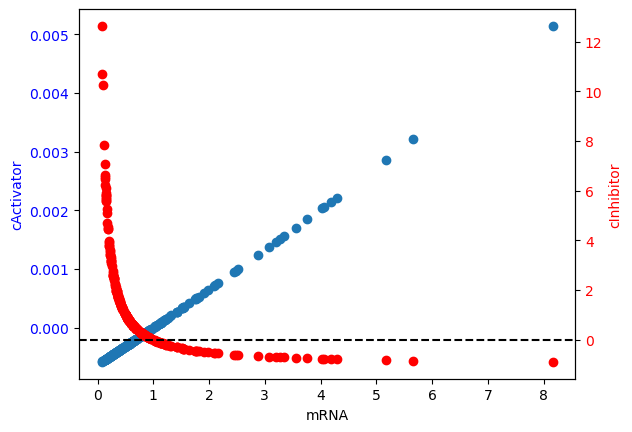

3.981071705534974e-09


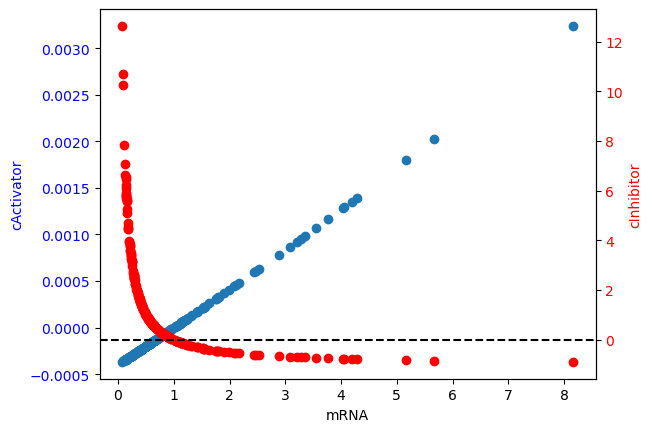

2.51188643150958e-09


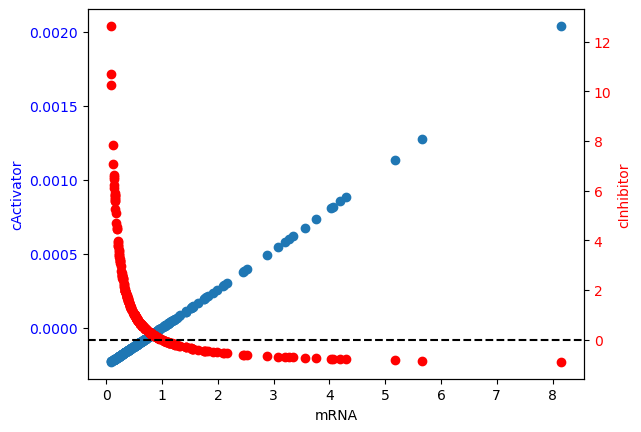

1.5848931924611142e-09


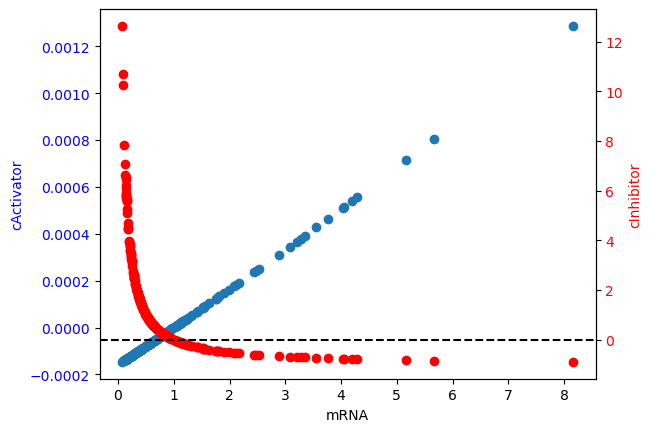

In [144]:
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it


# plot
for val in range(20):
    KdRNAPCrp_temp = KdRNAP*10**(-val/5)
    print(KdRNAPCrp_temp)
    fig, ax = plt.subplots()
    vals = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = KdRNAPCrp_temp)
    ax.scatter(ratios_df['actual_mRNA_ratio'], vals)
    plt.xlabel('mRNA')
    ax.set_ylabel('cActivator', color = 'blue')
    ax.tick_params(axis = 'y', labelcolor = 'blue')
    #ax.set_ylim(-max(abs(vals)), max(abs(vals)))
    ax2 = ax.twinx()
    vals = mRNA_to_cInhibitor(ratios_df['actual_mRNA_ratio'])
    ax2.scatter(ratios_df['actual_mRNA_ratio'], vals, color = 'red')
    ax2.set_ylabel('cInhibitor', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    #ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
    #plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
    #plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
    ax2.axhline(y = 0, linestyle = '--', color = 'k')
    plt.show()